In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

Dados baixados do [site de microdados da Anac](https://sistemas.anac.gov.br/sas/downloads/view/frmDownload)

(Data downloaded [Anac's microdata website](https://sistemas.anac.gov.br/sas/downloads/view/frmDownload))

In [3]:
df_all = pd.read_csv('dados/2012-2017_1.CSV', sep=';', decimal=',')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27856209 entries, 0 to 27856208
Data columns (total 7 columns):
ANO         int64
MES         int64
EMPRESA     object
ORIGEM      object
DESTINO     object
TARIFA      float64
ASSENTOS    int64
dtypes: float64(1), int64(3), object(3)
memory usage: 1.5+ GB


In [4]:
df_all['DTTM'] = pd.to_datetime(dict(year=df_all['ANO'], month=df_all['MES'], day=1))
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27856209 entries, 0 to 27856208
Data columns (total 8 columns):
ANO         int64
MES         int64
EMPRESA     object
ORIGEM      object
DESTINO     object
TARIFA      float64
ASSENTOS    int64
DTTM        datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 1.7+ GB


Vamos restringir a análise às tarifas populares (que seriam, em tese, as beneficiadas pela cobrança de bagagem à parte) emitidas pela Gol. Os dados não discriminam qual seria a tarifa popular, mas parece razoável considerar que ela seja a tarifa com maior número de assentos em cada trecho.

Let's restrict the analysis to popular tickets (the ones that should have been benefited from the separate luggage charging) issued by Gol airline. The data doesn't discriminate which tickets are the "popular" ones, but it seems reasonable to assume that the ticket with the greatest number of seats are the ones we're looking for.

In [5]:
df_gol = df_all[df_all['EMPRESA'] == 'GLO']
df_grouped = df_gol.groupby(['DTTM', 'ORIGEM', 'DESTINO'])
assentos_max = df_grouped['ASSENTOS'].max()
df_gol_popular = df_gol[df_gol['ASSENTOS'] == df_grouped['ASSENTOS'].transform('max')]

In [6]:
df_gol_popular.head()

,ANO,MES,EMPRESA,ORIGEM,DESTINO,TARIFA,ASSENTOS,DTTM
60484,2012,1,GLO,SBAR,SBMG,249.0,28,2012-01-01
60517,2012,1,GLO,SBLO,SBBV,249.0,2,2012-01-01
60538,2012,1,GLO,SBMO,SBJV,1353.9,2,2012-01-01
60543,2012,1,GLO,SBRF,SBDN,249.0,31,2012-01-01
60588,2012,1,GLO,SBRJ,SBPS,328.9,14,2012-01-01


Agora podemos tirar a mediana do valor das tarifas populares para cada mês ao longo de todos os trechos e plotar o resultado.

Now it's possible to take the median values of the popular tickets for each each month across all flights and plot the results.

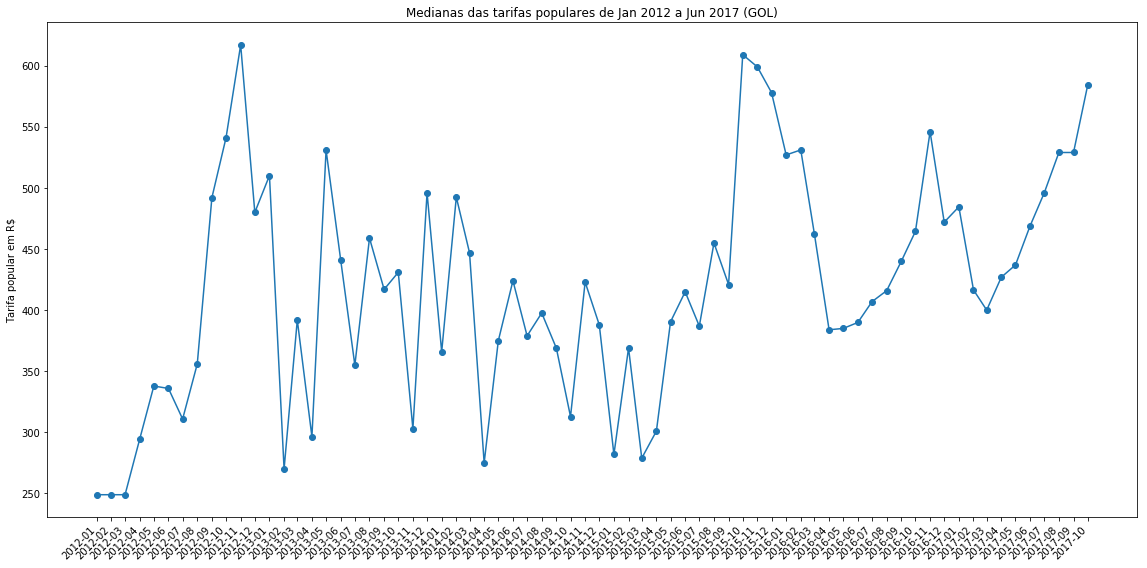

In [7]:
pivoted = pd.pivot_table(df_gol_popular, index=['DTTM'], values=['TARIFA'], aggfunc=np.median)

plt.rcParams["figure.figsize"] = (16, 8)
fig, ax = plt.subplots()
ax.set_xticks(pivoted.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title('Medianas das tarifas populares de Jan 2012 a Jun 2017 (GOL)')
ax.set_ylabel('Tarifa popular em R$')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()

plt.plot_date(x=pivoted.index, y=pivoted, ls='-')

Vamos ver agora apenas os valores nos meses de julho, quando a cobrança de bagagem à parte começou a valer:

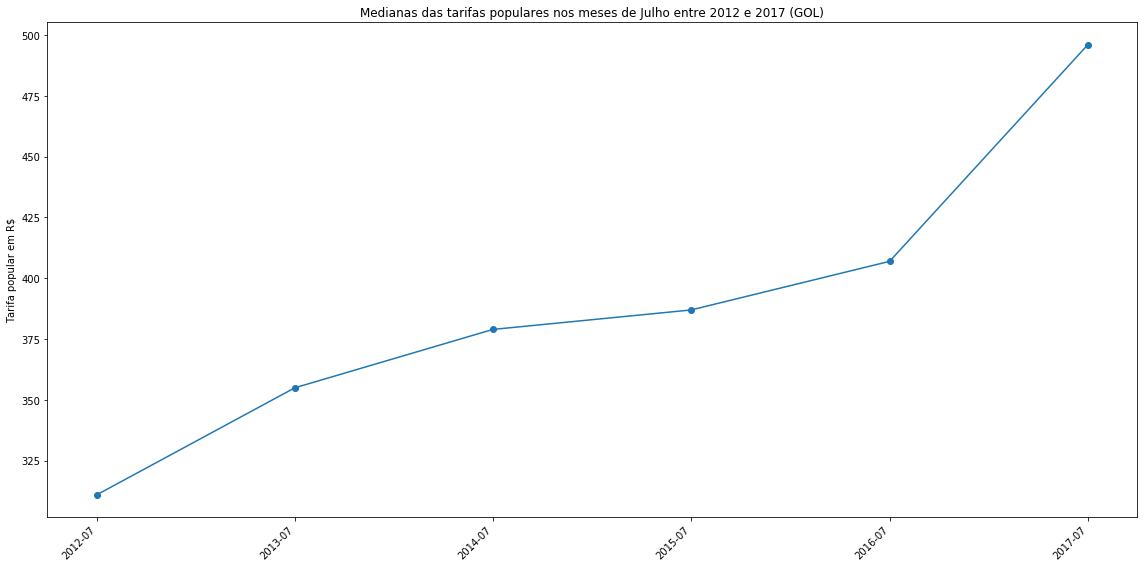

In [8]:
pivoted_julho = pd.pivot_table(df_gol_popular[df_gol_popular['MES'] == 7], index=['DTTM'], values=['TARIFA'], aggfunc=np.median)

plt.rcParams["figure.figsize"] = (16, 8)
fig, ax = plt.subplots()
ax.set_xticks(pivoted_julho.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title('Medianas das tarifas populares nos meses de Julho entre 2012 e 2017 (GOL)')
ax.set_ylabel('Tarifa popular em R$')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()

plt.plot_date(x=pivoted_julho.index, y=pivoted_julho, ls='-')

Precisamos corrigir esses preços pela inflação ao longo dos meses. Vamos usar a base de dados com a inflação acumulada mês a mês (IPCA) fornecida pelo Banco Central:

In [9]:
df_inflacao = pd.read_csv('dados/variacao_ipca.csv', sep=';', decimal=',')
df_inflacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
Data        70 non-null object
Variacao    70 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [10]:
df_inflacao.head()

,Data,Variacao
0,01/2012,0.56
1,02/2012,0.45
2,03/2012,0.21
3,04/2012,0.64
4,05/2012,0.36


In [11]:
df_inflacao['DTTM'] = pd.to_datetime(df_inflacao['Data'], format='%m/%Y')
df_inflacao.drop('Data', axis=1, inplace=True)
df_inflacao.head()

,Variacao,DTTM
0,0.56,2012-01-01
1,0.45,2012-02-01
2,0.21,2012-03-01
3,0.64,2012-04-01
4,0.36,2012-05-01


In [12]:
df_inflacao['Variacao'] = (df_inflacao['Variacao'] / 100.0) + 1.0
df_inflacao.head()

,Variacao,DTTM
0,1.0056,2012-01-01
1,1.0045,2012-02-01
2,1.0021,2012-03-01
3,1.0064,2012-04-01
4,1.0036,2012-05-01


O mês de Janeiro de 2012 será nossa base de preços, então podemos remover a variação da inflação nesse mês atribuindo o valor 1.0 a essa data:

In [13]:
df_inflacao_indexed = df_inflacao.set_index('DTTM')
df_inflacao_indexed.loc['2012-01-01', 'Variacao'] = 1.0
df_inflacao_indexed.head()

,Variacao
DTTM,
2012-01-01,1.0000
2012-02-01,1.0045
2012-03-01,1.0021
2012-04-01,1.0064
2012-05-01,1.0036


In [14]:
df_inflacao_indexed['Inflacao_acumulada'] = df_inflacao_indexed['Variacao'].cumprod()
df_inflacao_indexed.head()

,Variacao,Inflacao_acumulada
DTTM,,
2012-01-01,1.0000,1.000000
2012-02-01,1.0045,1.004500
2012-03-01,1.0021,1.006609
2012-04-01,1.0064,1.013052
2012-05-01,1.0036,1.016699


In [15]:
df_inflacao_indexed.tail()

,Variacao,Inflacao_acumulada
DTTM,,
2017-06-01,0.9977,1.411803
2017-07-01,1.0024,1.415191
2017-08-01,1.0019,1.417880
2017-09-01,1.0016,1.420148
2017-10-01,1.0042,1.426113


In [16]:
pivoted['TARIFA_CORRIGIDA'] = pivoted['TARIFA'] / df_inflacao_indexed['Inflacao_acumulada']
pivoted.tail()

,TARIFA,TARIFA_CORRIGIDA
DTTM,,
2017-06-01,468.9,332.128565
2017-07-01,495.9,350.412061
2017-08-01,528.9,373.021727
2017-09-01,528.9,372.425845
2017-10-01,583.9,409.434565


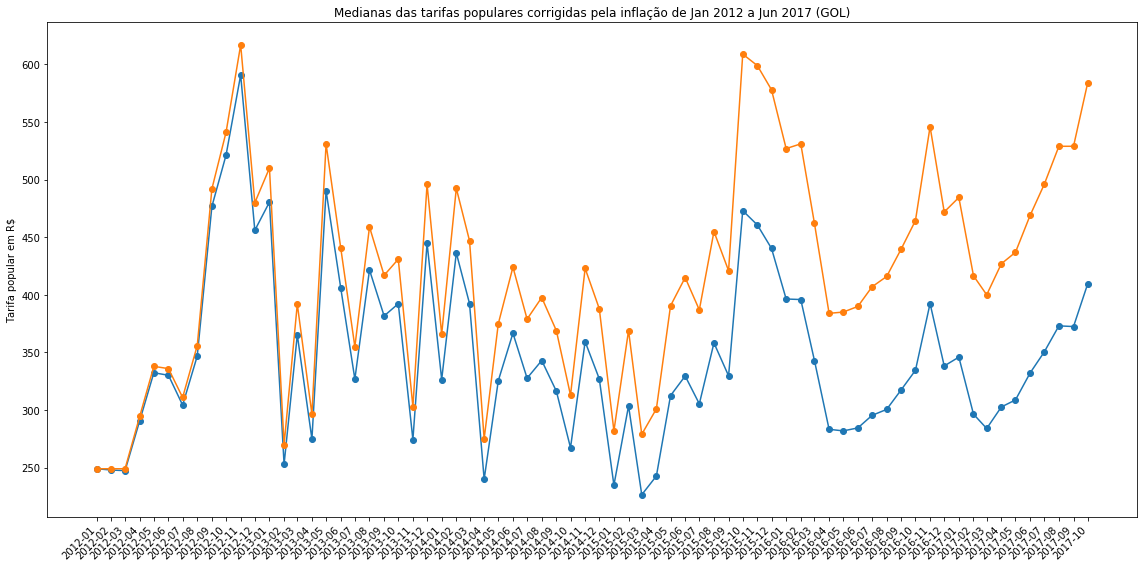

In [17]:
plt.rcParams["figure.figsize"] = (16, 8)
fig, ax = plt.subplots()
ax.set_xticks(pivoted.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title('Medianas das tarifas populares corrigidas pela inflação de Jan 2012 a Jun 2017 (GOL)')
ax.set_ylabel('Tarifa popular em R$')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()

## Como adicionar legendas ao gráfico? ax.legend() apenas mostra um quadrado vazio...
handle_tarifa_corrigida = plt.plot_date(x=pivoted.index, y=pivoted['TARIFA_CORRIGIDA'], ls='-')
handle_tarifa = plt.plot_date(x=pivoted.index, y=pivoted['TARIFA'], ls='-')

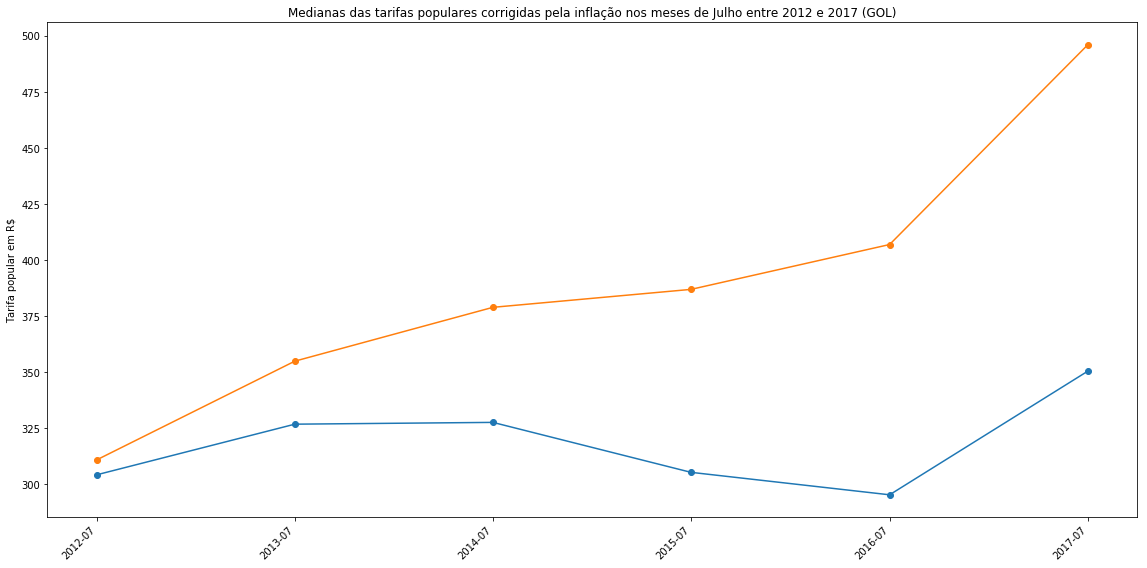

In [18]:
pivoted_julho = pivoted[pivoted.index.month == 7]

plt.rcParams["figure.figsize"] = (16, 8)
fig, ax = plt.subplots()
ax.set_xticks(pivoted_julho.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title('Medianas das tarifas populares corrigidas pela inflação nos meses de Julho entre 2012 e 2017 (GOL)')
ax.set_ylabel('Tarifa popular em R$')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()

plt.plot_date(x=pivoted_julho.index, y=pivoted_julho['TARIFA_CORRIGIDA'], ls='-')
plt.plot_date(x=pivoted_julho.index, y=pivoted_julho['TARIFA'], ls='-');

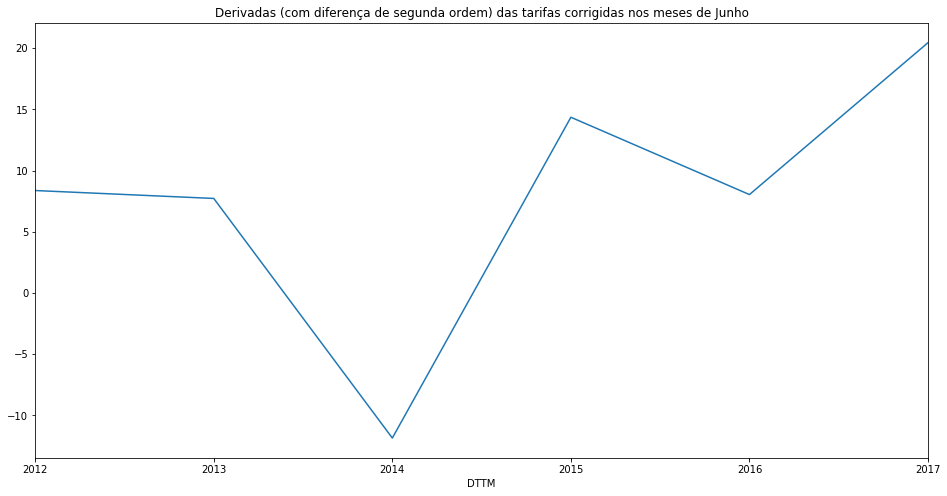

In [59]:
pivoted_junho = pivoted[pivoted.index.month == 6]
pivoted_agosto = pivoted[pivoted.index.month == 8]

derivadas_julho = pd.Series(index=pivoted_julho.index, data=(pivoted_agosto['TARIFA_CORRIGIDA'].values - pivoted_junho['TARIFA_CORRIGIDA'].values) / 2.0)
derivadas_julho.plot()
plt.title('Derivadas (com diferença de segunda ordem) das tarifas corrigidas nos meses de Junho');

In [82]:
media = np.mean(derivadas_julho.values[0:-1])
std = np.std(derivadas_julho.values[0:-1])

z_score = (derivadas_julho.values[-1] - media) / std

In [83]:
len([v for v in np.random.randn(100000) if v > z_score]) / 100000.0

0.04623

***Probabilidade desse resultado em Julho de 2017, dados os aumentos de Julho anteriores, é de cerca de 4%??***

## TODO
* Calcular as tendências (derivadas) em torno dos meses de Julho
* Fazer o teste de hipótese em cima dessas tendências